# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
from skimage.transform import resize
import pickle
from sklearn.model_selection import train_test_split


%matplotlib inline

# EDA

- "train.csv" file is available for downloading;
- The images are available as "train" and "test" files;
- The train files, "csv" and images will be splitted into train/test to build our models;
- The "test" image files will be used to generate the validation ".csv" file, which will be submitted as our solution for the competition 

In [2]:
file = pd.read_csv('data/train.csv')


In [3]:
file.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1738 entries, 0 to 1737
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1738 non-null   object
 1   Target          1738 non-null   object
dtypes: object(2)
memory usage: 27.3+ KB


In [4]:
file.head()

SOPInstanceUID Target
0  1.2.826.0.1.3680043.8.498.10025629581362719970...     0 
1  1.2.826.0.1.3680043.8.498.10036150326276641158...    15 
2  1.2.826.0.1.3680043.8.498.10038426859954986240...    12 
3  1.2.826.0.1.3680043.8.498.10050991192143676483...    14 
4  1.2.826.0.1.3680043.8.498.10053309524595490852...     3

In [5]:
file['Target'].value_counts()


3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

## Gathering image files paths and new DF

In [6]:
from pathlib import Path


In [7]:
images_train = Path().cwd().glob("**/train/**/*.dcm")
img_train_path_lst = [path for path in images_train]


In [8]:
images_test = Path().cwd().glob("**/test/**/*.dcm")
img_test_path_lst = [path for path in images_test]


In [8]:
img_train_path_lst[10]

PosixPath('/Users/sgp/Documents/Ironhack/UNIFESP/data/train/train/551/1.2.826.0.1.3680043.8.498.12712269899134516855972869509868235185/1.2.826.0.1.3680043.8.498.92431415960645296627687224582731905308/1.2.826.0.1.3680043.8.498.95024973449301076445329863637538348478-c.dcm')

In [9]:
sopi_lst_train = []
for i in range(len(img_train_path_lst)):
    ds_meta = pydicom.read_file(img_train_path_lst[i])
    elem = ds_meta[0x0008, 0x0018]
    sopi_lst_train.append(elem.value)

In [10]:
sopi_lst_train[10]

'1.2.826.0.1.3680043.8.498.95024973449301076445329863637538348478'

In [11]:
file.loc[10,'SOPInstanceUID']

'1.2.826.0.1.3680043.8.498.10080310665124574896848143784790467773'

As one can see above, the order of the images from the "train" file does NOT match the order of the dataframe created from the "train.csv" file.

To solve this problem:
- a temporary dataframe will be created, containing the image ID 'SOPInstanceUID' and the file path;
- merge the temporary dataframe with the original, on the 'SOPInstanceUID' column.

In [12]:
temp_df = pd.DataFrame.from_dict({'SOPInstanceUID' : sopi_lst_train, 'Path' : img_train_path_lst})

In [13]:
final_df = file.merge(temp_df, on='SOPInstanceUID', how='left').dropna()

In [14]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1738 entries, 0 to 1737
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1738 non-null   object
 1   Target          1738 non-null   object
 2   Path            1738 non-null   object
dtypes: object(3)
memory usage: 54.3+ KB


In [15]:
final_df.head()

SOPInstanceUID Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...     0    
1  1.2.826.0.1.3680043.8.498.10036150326276641158...    15    
2  1.2.826.0.1.3680043.8.498.10038426859954986240...    12    
3  1.2.826.0.1.3680043.8.498.10050991192143676483...    14    
4  1.2.826.0.1.3680043.8.498.10053309524595490852...     3    

                                                Path  
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...

In [16]:
final_df['Target'].value_counts()

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

## Labels
Some of the images ("SOPInstanceUID") are classified in more than one cluster of anatomical region, as shown in the cell above. In the next steps, following the labels ID below, we'll expand the dataframe, so, images with more than one classification will be replicated showing only one classification at a time:

    Abdomen = 0
    Ankle = 1
    Cervical Spine = 2
    Chest = 3
    Clavicles = 4
    Elbow = 5
    Feet = 6
    Finger = 7
    Forearm = 8
    Hand = 9
    Hip = 10
    Knee = 11
    Lower Leg = 12
    Lumbar Spine = 13
    Others = 14
    Pelvis = 15
    Shoulder = 16
    Sinus = 17
    Skull = 18
    Thigh = 19
    Thoracic Spine = 20
    Wrist = 21

Note - Others indicates whether the sample contains image of non X-ray images that sometimes are misplaced in the PACS system as X-Ray (eg. esophagogram, densitometry).

In [17]:
def splitDataFrameList(df,target_column,separator):
    ''' df = dataframe to split,
    target_column = the column containing the values to split
    separator = the symbol used to perform the split
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def splitListToRows(row, separator):
        split_row = row[target_column].split(separator)
        for s in split_row:
            new_row = row.to_dict()
            new_row[target_column] = s
            row_accumulator.append(new_row)

    df.apply(splitListToRows, axis=1, args = (separator, ))
    new_df = pd.DataFrame(row_accumulator)
    return new_df

In [18]:
lst_cols = [col for col in final_df.columns]


In [19]:
split_df = splitDataFrameList(final_df, lst_cols[1], " ")


In [20]:
split_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3618 entries, 0 to 3617
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  3618 non-null   object
 1   Target          3618 non-null   object
 2   Path            3618 non-null   object
dtypes: object(3)
memory usage: 84.9+ KB


In [21]:
file_clean = split_df[split_df['Target'] != '']
file_clean.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1880 entries, 0 to 3616
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1880 non-null   object
 1   Target          1880 non-null   object
 2   Path            1880 non-null   object
dtypes: object(3)
memory usage: 58.8+ KB


For easier visualization, a column with the label name is added.

In [22]:
df_label_temp = file_clean.copy()
df_label_temp['Target'] = df_label_temp['Target'].astype(int)


In [23]:
# Creating a dictionary for the labels

anatomy = {
0 : 'Abdomen' ,
1 : 'Ankle' ,
2 : 'Cervical Spine',
3 : 'Chest' ,
4 : 'Clavicles' ,
5 : 'Elbow' ,
6 : 'Feet' ,
7 : 'Finger' ,
8 : 'Forearm' ,
9 : 'Hand' ,
10 : 'Hip' ,
11 : 'Knee' ,
12 : 'Lower Leg' ,
13 : 'Lumbar Spine' ,
14 : 'Others' ,
15 : 'Pelvis',
16 : 'Shoulder' ,
17 : 'Sinus' ,
18 : 'Skull' ,
19 : 'Thigh' ,
20 : 'Thoracic Spine',
21: 'Wrist',
}


In [24]:
df_label_temp['Anatomy'] = df_label_temp['Target'].map(anatomy)
data_labeled = df_label_temp.reset_index(drop=True)


In [25]:
data_labeled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1880 entries, 0 to 1879
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  1880 non-null   object
 1   Target          1880 non-null   int64 
 2   Path            1880 non-null   object
 3   Anatomy         1880 non-null   object
dtypes: int64(1), object(3)
memory usage: 58.9+ KB


In [26]:
data_labeled.head()

SOPInstanceUID  Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...       0   
1  1.2.826.0.1.3680043.8.498.10036150326276641158...      15   
2  1.2.826.0.1.3680043.8.498.10038426859954986240...      12   
3  1.2.826.0.1.3680043.8.498.10050991192143676483...      14   
4  1.2.826.0.1.3680043.8.498.10053309524595490852...       3   

                                                Path    Anatomy  
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...    Abdomen  
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...     Pelvis  
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  Lower Leg  
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...     Others  
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...      Chest

In [27]:
data_labeled['Target'].value_counts()

3     738
14    120
11    110
21    105
0      92
13     87
2      81
6      78
9      74
15     71
20     64
1      54
16     41
12     26
5      25
10     25
17     23
7      17
8      15
19     15
18     10
4       9
Name: Target, dtype: int64

# Creating sample dataframe

In order to speed up the process, a sampled dataframe with few categories (labels) to be used in preliminary models

In [36]:
sample_df = data_labeled[(data_labeled['Target'] == 11) | (
    data_labeled['Target'] == 21)].reset_index(drop=True)

In [111]:
sample_df_6cat = data_labeled[(data_labeled['Target'] == 11) | (
                data_labeled['Target'] == 21) | (
                data_labeled['Target'] == 0) | (
                data_labeled['Target'] == 13) | (
                data_labeled['Target'] == 2) | (
                data_labeled['Target'] == 16)].reset_index(drop=True)

In [112]:
sample_df_7cat = data_labeled[(data_labeled['Target'] == 11) | (
                data_labeled['Target'] == 21) | (
                data_labeled['Target'] == 0) | (
                data_labeled['Target'] == 13) | (
                data_labeled['Target'] == 2) | (
                data_labeled['Target'] == 6) | (
                data_labeled['Target'] == 3)].reset_index(drop=True)

In [28]:
sample_df_semi = data_labeled[data_labeled['Target'] != 3]

In [113]:
sample_df_6cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 516 entries, 0 to 515
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   SOPInstanceUID  516 non-null    object
 1   Target          516 non-null    int64 
 2   Path            516 non-null    object
 3   Anatomy         516 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.2+ KB


In [114]:
sample_df_6cat.head()

SOPInstanceUID  Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...       0   
1  1.2.826.0.1.3680043.8.498.10065930002825553435...      13   
2  1.2.826.0.1.3680043.8.498.10107388868056003719...       0   
3  1.2.826.0.1.3680043.8.498.10135999234351484423...       2   
4  1.2.826.0.1.3680043.8.498.10166555243811009418...      21   

                                                Path         Anatomy  
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen  
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...    Lumbar Spine  
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen  
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  Cervical Spine  
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...           Wrist

In [117]:
# Creating a list with the path for each image of the sample

img_sample_lst_6cat = sample_df_6cat['Path'].tolist()
len(img_sample_lst_6cat)

516

# Image display and pixel_array

## DICOM Metadata

In [42]:
image = img_sample_lst[1]
ds = pydicom.read_file(image)


In [43]:
ds

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 244
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.8.498.10242799675195671634897807131985000448
(0002, 0010) Transfer Syntax UID                 UI: JPEG 2000 Image Compression (Lossless Only)
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.1143.107.104.103.115.3.0.10
(0002, 0013) Implementation Version Name         SH: 'GDCM 3.0.10'
(0002, 0016) Source Application Entity Title     AE: 'gdcmconv'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0012) Instance Creation Date              DA: ''
(0008, 0013) Instance Creation Time              TM: ''
(0008, 0016) SOP Class UID                       UI:

In [44]:
elem = ds[0x0008, 0x0018]
elem.value


'1.2.826.0.1.3680043.8.498.10242799675195671634897807131985000448'

## Image viewing

- Testing with on image from the sample list

In [82]:
image = img_train_lst[1]
ds = pydicom.read_file(image)


In [32]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
               
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
        
    return data


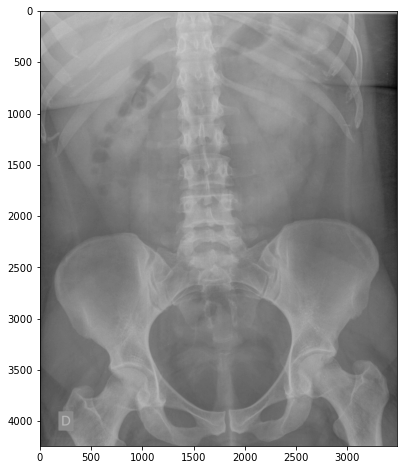

In [77]:
data = read_xray(img_sample_lst_semi[99])
plt.figure(figsize=(8, 8))
plt.imshow(data, 'gray');


In [37]:
data

array([[212, 214, 215, ..., 164, 165, 166],
       [208, 208, 206, ..., 163, 159, 159],
       [206, 207, 210, ..., 163, 165, 166],
       ...,
       [ 72,  76,  75, ...,  95,  96, 100],
       [ 76,  77,  73, ...,  94,  94,  96],
       [ 79,  75,  72, ...,  95,  96,  98]], dtype=uint8)

In [38]:
data.shape

(4240, 3480)

### PCA for 1 image

- Applying PCA decomposition for one image matrix (pixel array)

In [75]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [78]:
scaled_img = StandardScaler().fit_transform(data)


In [79]:
pca = PCA(n_components=100)
pca_data = pca.fit_transform(scaled_img)


In [80]:
pca_data

array([[ 2.33521096e+02,  6.38418156e+01,  5.49901389e+01, ...,
        -1.46950803e+00, -3.41770264e-02,  1.52547330e+00],
       [ 2.26287023e+02,  6.05360385e+01,  5.57399183e+01, ...,
        -1.27297881e+00,  3.26184084e-01,  9.22763615e-01],
       [ 2.20063113e+02,  5.84768788e+01,  5.56885855e+01, ...,
        -1.38966316e+00,  9.18077202e-01,  1.09294302e+00],
       ...,
       [-6.06909701e+01,  1.53396704e+01,  3.98714945e+01, ...,
         2.38132032e-01,  2.50826035e-01,  3.23015230e-01],
       [-6.10617598e+01,  1.55228257e+01,  3.99778276e+01, ...,
        -1.26948729e-01,  3.27298887e-01, -1.19880325e-01],
       [-6.09135390e+01,  1.57464629e+01,  4.01118566e+01, ...,
         1.23527360e-01,  4.72740147e-01, -1.03434873e-01]])

In [81]:
pca_data.shape

(4240, 100)

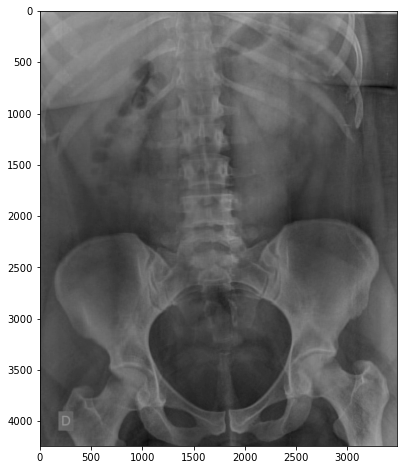

In [82]:
plt.figure(figsize=(8, 8))
plt.imshow(pca.inverse_transform(pca_data), cmap='gray');


In [83]:
pca_i_lst = []
pca_data_lst = []
j=0
for i in (5,30,60,100):
    scaled_img = StandardScaler().fit_transform(data)
    pca = PCA(n_components=int(i))
    pca_data = pca.fit_transform(scaled_img)
    pca_data_lst.append(pca_data)
    pca_i = pca.inverse_transform(pca_data_lst[j])
    j += 1
    pca_i_lst.append(pca_i)

In [84]:
len(pca_data_lst)


4

In [85]:
pca_data_lst[0]

array([[233.52109613,  63.84181562,  54.99013905,  62.71650889,
         56.7992398 ],
       [226.2870231 ,  60.53603845,  55.73991838,  65.14315095,
         57.16113382],
       [220.06311313,  58.47687884,  55.68858563,  67.10851678,
         58.39846701],
       ...,
       [-60.69097014,  15.33967038,  39.87149455, -46.54955115,
          9.35465935],
       [-61.06175983,  15.52282566,  39.9778276 , -46.42074168,
          9.51122183],
       [-60.91353904,  15.74646291,  40.11185655, -46.24266405,
          9.65989145]])

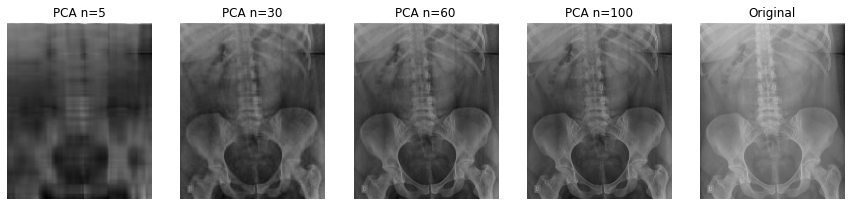

In [91]:
fig, ax = plt.subplots(1, 5, figsize=(15, 15))
ax[0].imshow(pca_i_lst[0], 'gray')
ax[0].set_title("PCA n=5")
ax[0].axis('off')
ax[1].imshow(pca_i_lst[1], 'gray')
ax[1].set_title("PCA n=30")
ax[1].axis('off')
ax[2].imshow(pca_i_lst[2], 'gray')
ax[2].set_title("PCA n=60")
ax[2].axis('off')
ax[3].imshow(pca_i_lst[3], 'gray')
ax[3].set_title("PCA n=100")
ax[3].axis('off')
ax[4].imshow(data, 'gray')
ax[4].set_title("Original")
ax[4].axis('off');

# Vectorizing and PCA

## Building list of image vectors

* From the arrays (matrices) from "train" and "test" image files, will:
    - resize (1000 x 1000);
    - transform each one into a vector with a 1e6 elements;
    - standardize the vectors;
    - apply a decomposition method (PCA)

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from skimage.transform import resize
import pickle

In [52]:
vector_train_lst = []
for i in range(len(img_train_lst)):
    raw_img = read_xray(img_train_lst[i])
    image = resize(raw_img, (1000, 1000), anti_aliasing=True)
    vector_data = np.ravel(image)
    vector_train_lst.append(vector_data)
vector_train_array = np.array(vector_train_lst)
with open('vector_train_lst.pkl', 'wb') as f:
    pickle.dump(vector_train_lst, f)   
vector_train_array.shape


In [32]:
with open('vector_train_lst.pkl', 'rb') as f:
    vector_train_lst = pickle.load(f)

In [39]:
len(vector_train_lst)


1880

In [34]:
vector_train_array = np.array(vector_train_lst)

In [38]:
vector_train_array.shape

(1880, 1000000)

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(8,8))
ax[0].imshow(vector_train_array[0].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[1].imshow(vector_train_array[1].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[2].imshow(vector_train_array[4].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[3].imshow(vector_train_array[6].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[4].imshow(vector_train_array[8].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest')
ax[5].imshow(vector_train_array[9].reshape(1000,1000), cmap=plt.cm.bone, interpolation='nearest');


In [ ]:
vector_test_lst = []
for i in range(len(img_test_path_lst)):
    raw_img = read_xray(img_test_path_lst[i])
    image = resize(raw_img, (1000, 1000), anti_aliasing=True)
    vector_data = np.ravel(image)
    vector_test_lst.append(vector_data)
vector_test_array = np.array(vector_test_lst)
with open('vector_test_lst.pkl', 'wb') as f:
    pickle.dump(vector_test_lst, f)
vector_test_array.shape


In [205]:
with open('vector_sample_lst_2cat.pkl', 'rb') as file:
    vector_sample_lst_2cat = pickle.load(file)
    

In [53]:
len(vector_sample_lst_6cat)


553

In [118]:
vector_sample_lst_6cat = []
for i in range(len(img_sample_lst_6cat)):
    raw_img = read_xray(img_sample_lst_6cat[i])
    image = resize(raw_img, (1000, 1000), anti_aliasing=True)
    vector_data = np.ravel(image)
    vector_sample_lst_6cat.append(vector_data)
vector_sample_array_6cat = np.array(vector_sample_lst_6cat)
with open('vector_sample_lst_6cat.pkl', 'wb') as f:
    pickle.dump(vector_sample_lst_6cat, f)
vector_sample_array_6cat.shape


(516, 1000000)

In [34]:
with open('vector_sample_lst_semi.pkl', 'rb') as file:
    vector_sample_lst_semi = pickle.load(file)

In [35]:
vector_sample_array_semi = np.array(vector_sample_lst_semi)

In [36]:
vector_sample_array_semi.shape

(1142, 1000000)

## Splitting sample df

In [37]:
from sklearn.model_selection import train_test_split


In [120]:
X = vector_sample_array_6cat
y = sample_df_6cat['Target']


In [121]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)


In [122]:
len(X_train)


412

## Pickle

In [55]:
import pickle


In [66]:
with open('vector_sample_lst.pkl', 'wb') as f:
    pickle.dump(vector_sample_lst, f)

In [78]:
with open('vector_sample_lst2.pkl', 'rb') as f:
    vector_sample_lst2 = pickle.load(f)
    

In [416]:
vector_train_array = np.array(vector_train_lst)

In [206]:
len(vector_sample_lst_2cat)

215

## Adding arrays to dataframe

In [ ]:
file.info()


In [ ]:
file['image_vector'] = vector_train_lst

In [ ]:
with open('vector_test_lst.pkl', 'wb') as test:
    pickle.dump(vector_test_lst, test)
    

In [ ]:
with open('vector_train_lst.pkl', 'wb') as train:
    pickle.dump(vector_train_array, train)
    

## PCA

### Normalization

In [123]:
scaler = StandardScaler()
scaled_img_train = scaler.fit_transform(X_train)

In [124]:
scaled_img_test = scaler.transform(X_test)

### Kneed

In [209]:
pca = PCA() 
pca.fit(scaled_img_train)

PCA()

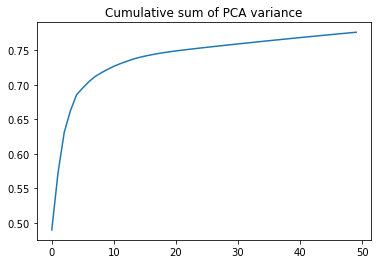

In [165]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title("Cumulative sum of PCA variance");

n_components suggested : 18


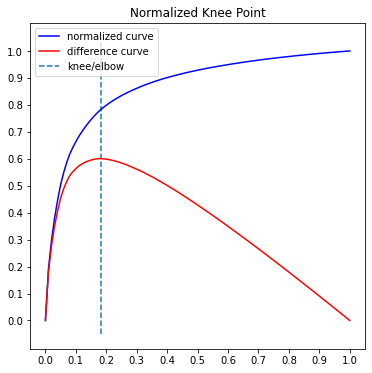

In [113]:
from kneed import KneeLocator
knee_fit = KneeLocator(range(len(pca.explained_variance_ratio_)), 
                       np.cumsum(pca.explained_variance_ratio_))
print(f"n_components suggested : {knee_fit.knee}")
knee_fit.plot_knee_normalized()


### PCA

In [125]:
#'arpack', svd_solver='randomized'

pca = PCA(n_components=50)
pca_data_train = pca.fit_transform(scaled_img_train)

In [126]:
pca_data_test = pca.transform(scaled_img_test)

In [127]:
pca_data_train.shape


(412, 50)

In [128]:
pca_data_train_df = pd.DataFrame(pca_data_train, columns = ['PC' + str(i) for i in range(pca.n_components_)])
pca_data_test_df = pd.DataFrame(pca_data_test, columns = ['PC' + str(i) for i in range(pca.n_components_)])


In [129]:
pca_data_train_df.head()

PC0         PC1         PC2         PC3         PC4         PC5  \
0  516.037029  773.842390  139.866719 -236.326943   73.047614  -49.097707   
1  363.028026 -386.837299   27.897107 -221.539524  143.263428 -279.825327   
2   -5.187272    0.059590  113.240373  104.100414  166.034258 -134.546878   
3  539.000611  -56.957369  206.398245 -107.786702   96.196887   78.148664   
4  203.365752  703.275228 -228.206824 -316.038525 -202.855557 -438.247938   

          PC6         PC7         PC8         PC9  ...       PC40       PC41  \
0   -6.962583   52.373824  -85.175401  286.436429  ... -21.184317 -10.575559   
1 -192.089270   23.016660  -49.727760  119.686383  ...  75.943250 -31.001004   
2   94.657315  112.962966   -6.865237  103.535878  ...  11.028810 -15.924330   
3   47.891361    4.038289   59.793386   87.603360  ...  15.098136   0.268229   
4   70.031047  125.918886 -213.054440 -142.871373  ...  51.570346  -3.142683   

        PC42       PC43       PC44       PC45       PC46       PC47  \
0  32.257757 -16.664122  10.669468  69.982167 -13.558768 -71.928491   
1  85.526049 -92.587832 -23.392805  -8.725339  19.283651 -88.317630   
2  34.685128 -10.130096  18.074451 -15.931517  23.066537  12.505380   
3  13.907455 -60.330441   1.115607  64.723002   1.330310   2.118692   
4 -72.951455  30.055251  95.494879 -26.542040  79.917805  41.009368   

        PC48       PC49  
0  68.778842  24.788870  
1  27.787121  35.146551  
2 -21.786983  24.261579  
3  -7.895055  35.217051  
4 -63.633319  35.581153  

[5 rows x 50 columns]

## Aggregating the PCA data to the original dataframe 

In [134]:
train_pca_df = pd.concat([sample_df_6cat, pca_data_train_df], axis=1)
test_pca_df = pd.concat([sample_df_6cat, pca_data_train_df], axis=1)


In [135]:
# train_pca_df['Target'] = sample_final['Target'].astype(int)


In [136]:
train_pca_df.head()


SOPInstanceUID  Target  \
0  1.2.826.0.1.3680043.8.498.10025629581362719970...       0   
1  1.2.826.0.1.3680043.8.498.10065930002825553435...      13   
2  1.2.826.0.1.3680043.8.498.10107388868056003719...       0   
3  1.2.826.0.1.3680043.8.498.10135999234351484423...       2   
4  1.2.826.0.1.3680043.8.498.10166555243811009418...      21   

                                                Path         Anatomy  \
0  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen   
1  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...    Lumbar Spine   
2  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...         Abdomen   
3  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...  Cervical Spine   
4  /Users/sgp/Documents/Ironhack/UNIFESP/data/tra...           Wrist   

          PC0         PC1         PC2         PC3         PC4         PC5  \
0  516.037029  773.842390  139.866719 -236.326943   73.047614  -49.097707   
1  363.028026 -386.837299   27.897107 -221.539524  143.263428 -279.825327   
2   -5.187272    0.059590  113.240373  104.100414  166.034258 -134.546878   
3  539.000611  -56.957369  206.398245 -107.786702   96.196887   78.148664   
4  203.365752  703.275228 -228.206824 -316.038525 -202.855557 -438.247938   

   ...       PC40       PC41       PC42       PC43       PC44       PC45  \
0  ... -21.184317 -10.575559  32.257757 -16.664122  10.669468  69.982167   
1  ...  75.943250 -31.001004  85.526049 -92.587832 -23.392805  -8.725339   
2  ...  11.028810 -15.924330  34.685128 -10.130096  18.074451 -15.931517   
3  ...  15.098136   0.268229  13.907455 -60.330441   1.115607  64.723002   
4  ...  51.570346  -3.142683 -72.951455  30.055251  95.494879 -26.542040   

        PC46       PC47       PC48       PC49  
0 -13.558768 -71.928491  68.778842  24.788870  
1  19.283651 -88.317630  27.787121  35.146551  
2  23.066537  12.505380 -21.786983  24.261579  
3   1.330310   2.118692  -7.895055  35.217051  
4  79.917805  41.009368 -63.633319  35.581153  

[5 rows x 54 columns]

## Example of image recomposition from PCA data


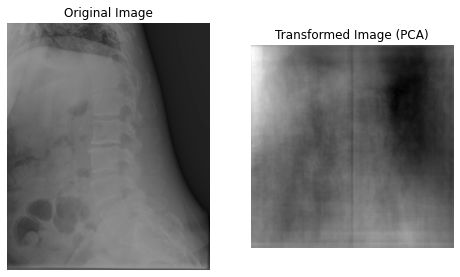

In [157]:
fig, ax = plt.subplots(1,2, figsize=(8,8))
ax[0].imshow(read_xray(sample_df_6cat.loc[47, 'Path']), 'gray')
ax[0].set_title("Original Image")
ax[0].axis('off')
ax[1].imshow(pca.inverse_transform(pca_data_test_df.iloc[7,]).reshape(1000,1000), 'gray');
ax[1].set_title("Transformed Image (PCA)")
ax[1].axis('off');

# Models

## Catboost

In [98]:
import catboost as cat
from sklearn.metrics import f1_score


In [132]:
cat_fit = cat.CatBoostClassifier(
    iterations=20000, depth=8, auto_class_weights="Balanced", od_type="Iter", od_wait=500)
cat_fit.fit(pca_data_train, y_train,
            eval_set=(pca_data_test, y_test))


Learning rate set to 0.033778
0:	learn: 1.7809083	test: 1.7898679	best: 1.7898679 (0)	total: 246ms	remaining: 1h 22m 3s
1:	learn: 1.7679505	test: 1.7868979	best: 1.7868979 (1)	total: 615ms	remaining: 1h 42m 32s
2:	learn: 1.7553844	test: 1.7854655	best: 1.7854655 (2)	total: 794ms	remaining: 1h 28m 14s
3:	learn: 1.7446617	test: 1.7811796	best: 1.7811796 (3)	total: 1.09s	remaining: 1h 30m 38s
4:	learn: 1.7329202	test: 1.7760409	best: 1.7760409 (4)	total: 1.34s	remaining: 1h 29m 10s
5:	learn: 1.7200927	test: 1.7726761	best: 1.7726761 (5)	total: 1.61s	remaining: 1h 29m 43s
6:	learn: 1.7061979	test: 1.7685453	best: 1.7685453 (6)	total: 1.85s	remaining: 1h 28m 20s
7:	learn: 1.6919740	test: 1.7638412	best: 1.7638412 (7)	total: 2.06s	remaining: 1h 25m 49s
8:	learn: 1.6800776	test: 1.7591081	best: 1.7591081 (8)	total: 2.27s	remaining: 1h 24m 13s
9:	learn: 1.6693584	test: 1.7576339	best: 1.7576339 (9)	total: 2.52s	remaining: 1h 23m 57s
10:	learn: 1.6589812	test: 1.7546533	best: 1.7546533 (10)	tot

92:	learn: 0.9876340	test: 1.5262542	best: 1.5262542 (92)	total: 13.4s	remaining: 47m 41s
93:	learn: 0.9823759	test: 1.5249490	best: 1.5249490 (93)	total: 13.5s	remaining: 47m 30s
94:	learn: 0.9767456	test: 1.5229544	best: 1.5229544 (94)	total: 13.5s	remaining: 47m 18s
95:	learn: 0.9706900	test: 1.5208790	best: 1.5208790 (95)	total: 13.7s	remaining: 47m 10s
96:	learn: 0.9662883	test: 1.5198466	best: 1.5198466 (96)	total: 13.7s	remaining: 47m
97:	learn: 0.9605196	test: 1.5181881	best: 1.5181881 (97)	total: 13.8s	remaining: 46m 49s
98:	learn: 0.9548787	test: 1.5145611	best: 1.5145611 (98)	total: 13.9s	remaining: 46m 39s
99:	learn: 0.9495672	test: 1.5125448	best: 1.5125448 (99)	total: 14s	remaining: 46m 28s
100:	learn: 0.9451435	test: 1.5123061	best: 1.5123061 (100)	total: 14.1s	remaining: 46m 18s
101:	learn: 0.9399152	test: 1.5122316	best: 1.5122316 (101)	total: 14.2s	remaining: 46m 9s
102:	learn: 0.9358335	test: 1.5111842	best: 1.5111842 (102)	total: 14.3s	remaining: 46m 5s
103:	learn: 

183:	learn: 0.6112126	test: 1.4053215	best: 1.4053215 (183)	total: 24.7s	remaining: 44m 16s
184:	learn: 0.6075610	test: 1.4031089	best: 1.4031089 (184)	total: 24.7s	remaining: 44m 10s
185:	learn: 0.6045842	test: 1.4025726	best: 1.4025726 (185)	total: 24.8s	remaining: 44m 5s
186:	learn: 0.6015650	test: 1.4017251	best: 1.4017251 (186)	total: 24.9s	remaining: 44m
187:	learn: 0.5978084	test: 1.3991946	best: 1.3991946 (187)	total: 25s	remaining: 43m 55s
188:	learn: 0.5948377	test: 1.3977506	best: 1.3977506 (188)	total: 25.1s	remaining: 43m 50s
189:	learn: 0.5922007	test: 1.3952176	best: 1.3952176 (189)	total: 25.2s	remaining: 43m 45s
190:	learn: 0.5896734	test: 1.3937479	best: 1.3937479 (190)	total: 25.3s	remaining: 43m 40s
191:	learn: 0.5865632	test: 1.3926208	best: 1.3926208 (191)	total: 25.4s	remaining: 43m 35s
192:	learn: 0.5834201	test: 1.3909521	best: 1.3909521 (192)	total: 25.4s	remaining: 43m 31s
193:	learn: 0.5811276	test: 1.3903997	best: 1.3903997 (193)	total: 25.5s	remaining: 43m

275:	learn: 0.3781004	test: 1.2709386	best: 1.2709386 (275)	total: 35.8s	remaining: 42m 38s
276:	learn: 0.3760568	test: 1.2687781	best: 1.2687781 (276)	total: 35.9s	remaining: 42m 34s
277:	learn: 0.3741175	test: 1.2677306	best: 1.2677306 (277)	total: 36s	remaining: 42m 31s
278:	learn: 0.3724559	test: 1.2668600	best: 1.2668600 (278)	total: 36.1s	remaining: 42m 28s
279:	learn: 0.3702188	test: 1.2637499	best: 1.2637499 (279)	total: 36.1s	remaining: 42m 25s
280:	learn: 0.3682606	test: 1.2614722	best: 1.2614722 (280)	total: 36.2s	remaining: 42m 21s
281:	learn: 0.3661357	test: 1.2598638	best: 1.2598638 (281)	total: 36.3s	remaining: 42m 18s
282:	learn: 0.3643662	test: 1.2585087	best: 1.2585087 (282)	total: 36.4s	remaining: 42m 15s
283:	learn: 0.3627094	test: 1.2564526	best: 1.2564526 (283)	total: 36.5s	remaining: 42m 13s
284:	learn: 0.3610916	test: 1.2553696	best: 1.2553696 (284)	total: 36.6s	remaining: 42m 10s
285:	learn: 0.3592527	test: 1.2543657	best: 1.2543657 (285)	total: 36.7s	remaining

365:	learn: 0.2578795	test: 1.1807994	best: 1.1807994 (365)	total: 46.2s	remaining: 41m 18s
366:	learn: 0.2570017	test: 1.1805802	best: 1.1805802 (366)	total: 46.3s	remaining: 41m 16s
367:	learn: 0.2560427	test: 1.1802455	best: 1.1802455 (367)	total: 46.4s	remaining: 41m 14s
368:	learn: 0.2550696	test: 1.1789832	best: 1.1789832 (368)	total: 46.5s	remaining: 41m 13s
369:	learn: 0.2541010	test: 1.1790190	best: 1.1789832 (368)	total: 46.6s	remaining: 41m 10s
370:	learn: 0.2530199	test: 1.1781557	best: 1.1781557 (370)	total: 46.7s	remaining: 41m 8s
371:	learn: 0.2522658	test: 1.1776274	best: 1.1776274 (371)	total: 46.8s	remaining: 41m 6s
372:	learn: 0.2512432	test: 1.1765830	best: 1.1765830 (372)	total: 46.8s	remaining: 41m 4s
373:	learn: 0.2504061	test: 1.1761115	best: 1.1761115 (373)	total: 46.9s	remaining: 41m 2s
374:	learn: 0.2494631	test: 1.1756668	best: 1.1756668 (374)	total: 47s	remaining: 41m 1s
375:	learn: 0.2485779	test: 1.1757765	best: 1.1756668 (374)	total: 47.1s	remaining: 40m

457:	learn: 0.1917172	test: 1.1408518	best: 1.1408518 (457)	total: 57.4s	remaining: 40m 48s
458:	learn: 0.1911850	test: 1.1402859	best: 1.1402859 (458)	total: 57.5s	remaining: 40m 46s
459:	learn: 0.1906967	test: 1.1402013	best: 1.1402013 (459)	total: 57.5s	remaining: 40m 44s
460:	learn: 0.1903207	test: 1.1403815	best: 1.1402013 (459)	total: 57.6s	remaining: 40m 42s
461:	learn: 0.1898080	test: 1.1399392	best: 1.1399392 (461)	total: 57.7s	remaining: 40m 40s
462:	learn: 0.1892973	test: 1.1396662	best: 1.1396662 (462)	total: 57.8s	remaining: 40m 39s
463:	learn: 0.1888268	test: 1.1392095	best: 1.1392095 (463)	total: 57.9s	remaining: 40m 37s
464:	learn: 0.1883588	test: 1.1388828	best: 1.1388828 (464)	total: 58s	remaining: 40m 36s
465:	learn: 0.1879831	test: 1.1392265	best: 1.1388828 (464)	total: 58.1s	remaining: 40m 34s
466:	learn: 0.1875549	test: 1.1392361	best: 1.1388828 (464)	total: 58.2s	remaining: 40m 33s
467:	learn: 0.1869716	test: 1.1394961	best: 1.1388828 (464)	total: 58.3s	remaining

548:	learn: 0.1522175	test: 1.1214609	best: 1.1214609 (548)	total: 1m 8s	remaining: 40m 25s
549:	learn: 0.1518194	test: 1.1213105	best: 1.1213105 (549)	total: 1m 8s	remaining: 40m 23s
550:	learn: 0.1515310	test: 1.1209704	best: 1.1209704 (550)	total: 1m 8s	remaining: 40m 21s
551:	learn: 0.1511243	test: 1.1207702	best: 1.1207702 (551)	total: 1m 8s	remaining: 40m 20s
552:	learn: 0.1507262	test: 1.1205156	best: 1.1205156 (552)	total: 1m 8s	remaining: 40m 18s
553:	learn: 0.1503869	test: 1.1205642	best: 1.1205156 (552)	total: 1m 8s	remaining: 40m 17s
554:	learn: 0.1500772	test: 1.1203201	best: 1.1203201 (554)	total: 1m 8s	remaining: 40m 16s
555:	learn: 0.1496642	test: 1.1194338	best: 1.1194338 (555)	total: 1m 9s	remaining: 40m 14s
556:	learn: 0.1492350	test: 1.1197992	best: 1.1194338 (555)	total: 1m 9s	remaining: 40m 13s
557:	learn: 0.1488468	test: 1.1195097	best: 1.1194338 (555)	total: 1m 9s	remaining: 40m 11s
558:	learn: 0.1484496	test: 1.1190155	best: 1.1190155 (558)	total: 1m 9s	remaini

638:	learn: 0.1248264	test: 1.1052444	best: 1.1052166 (637)	total: 1m 19s	remaining: 39m 55s
639:	learn: 0.1245752	test: 1.1054712	best: 1.1052166 (637)	total: 1m 19s	remaining: 39m 54s
640:	learn: 0.1243205	test: 1.1053603	best: 1.1052166 (637)	total: 1m 19s	remaining: 39m 54s
641:	learn: 0.1240756	test: 1.1054648	best: 1.1052166 (637)	total: 1m 19s	remaining: 39m 57s
642:	learn: 0.1237817	test: 1.1051035	best: 1.1051035 (642)	total: 1m 19s	remaining: 39m 59s
643:	learn: 0.1235452	test: 1.1051488	best: 1.1051035 (642)	total: 1m 19s	remaining: 40m
644:	learn: 0.1232740	test: 1.1050688	best: 1.1050688 (644)	total: 1m 20s	remaining: 40m 2s
645:	learn: 0.1230636	test: 1.1050359	best: 1.1050359 (645)	total: 1m 20s	remaining: 40m 4s
646:	learn: 0.1228391	test: 1.1049140	best: 1.1049140 (646)	total: 1m 20s	remaining: 40m 6s
647:	learn: 0.1225940	test: 1.1050224	best: 1.1049140 (646)	total: 1m 20s	remaining: 40m 8s
648:	learn: 0.1224249	test: 1.1052573	best: 1.1049140 (646)	total: 1m 20s	rema

727:	learn: 0.1064368	test: 1.0949331	best: 1.0948308 (726)	total: 1m 29s	remaining: 39m 28s
728:	learn: 0.1063104	test: 1.0946146	best: 1.0946146 (728)	total: 1m 29s	remaining: 39m 28s
729:	learn: 0.1061432	test: 1.0946313	best: 1.0946146 (728)	total: 1m 29s	remaining: 39m 27s
730:	learn: 0.1060503	test: 1.0943779	best: 1.0943779 (730)	total: 1m 29s	remaining: 39m 27s
731:	learn: 0.1059392	test: 1.0945055	best: 1.0943779 (730)	total: 1m 29s	remaining: 39m 27s
732:	learn: 0.1058165	test: 1.0943726	best: 1.0943726 (732)	total: 1m 30s	remaining: 39m 27s
733:	learn: 0.1056470	test: 1.0945022	best: 1.0943726 (732)	total: 1m 30s	remaining: 39m 27s
734:	learn: 0.1054959	test: 1.0947734	best: 1.0943726 (732)	total: 1m 30s	remaining: 39m 30s
735:	learn: 0.1053300	test: 1.0950654	best: 1.0943726 (732)	total: 1m 30s	remaining: 39m 31s
736:	learn: 0.1051631	test: 1.0950553	best: 1.0943726 (732)	total: 1m 30s	remaining: 39m 33s
737:	learn: 0.1049708	test: 1.0953561	best: 1.0943726 (732)	total: 1m 

817:	learn: 0.0928078	test: 1.0903431	best: 1.0903431 (817)	total: 1m 40s	remaining: 39m 28s
818:	learn: 0.0926810	test: 1.0903103	best: 1.0903103 (818)	total: 1m 41s	remaining: 39m 29s
819:	learn: 0.0925513	test: 1.0905508	best: 1.0903103 (818)	total: 1m 41s	remaining: 39m 30s
820:	learn: 0.0924535	test: 1.0902080	best: 1.0902080 (820)	total: 1m 41s	remaining: 39m 32s
821:	learn: 0.0923506	test: 1.0904606	best: 1.0902080 (820)	total: 1m 41s	remaining: 39m 34s
822:	learn: 0.0922072	test: 1.0906306	best: 1.0902080 (820)	total: 1m 42s	remaining: 39m 37s
823:	learn: 0.0920814	test: 1.0901981	best: 1.0901981 (823)	total: 1m 42s	remaining: 39m 38s
824:	learn: 0.0919318	test: 1.0898032	best: 1.0898032 (824)	total: 1m 42s	remaining: 39m 40s
825:	learn: 0.0919051	test: 1.0898121	best: 1.0898032 (824)	total: 1m 42s	remaining: 39m 41s
826:	learn: 0.0917407	test: 1.0895625	best: 1.0895625 (826)	total: 1m 42s	remaining: 39m 44s
827:	learn: 0.0915500	test: 1.0895205	best: 1.0895205 (827)	total: 1m 

907:	learn: 0.0820616	test: 1.0812239	best: 1.0812239 (907)	total: 1m 52s	remaining: 39m 25s
908:	learn: 0.0820422	test: 1.0811892	best: 1.0811892 (908)	total: 1m 52s	remaining: 39m 26s
909:	learn: 0.0819172	test: 1.0812397	best: 1.0811892 (908)	total: 1m 52s	remaining: 39m 28s
910:	learn: 0.0818612	test: 1.0812737	best: 1.0811892 (908)	total: 1m 53s	remaining: 39m 28s
911:	learn: 0.0817674	test: 1.0814160	best: 1.0811892 (908)	total: 1m 53s	remaining: 39m 30s
912:	learn: 0.0816462	test: 1.0810305	best: 1.0810305 (912)	total: 1m 53s	remaining: 39m 30s
913:	learn: 0.0814786	test: 1.0804132	best: 1.0804132 (913)	total: 1m 53s	remaining: 39m 32s
914:	learn: 0.0813470	test: 1.0803013	best: 1.0803013 (914)	total: 1m 53s	remaining: 39m 33s
915:	learn: 0.0812366	test: 1.0802999	best: 1.0802999 (915)	total: 1m 53s	remaining: 39m 34s
916:	learn: 0.0811277	test: 1.0801733	best: 1.0801733 (916)	total: 1m 54s	remaining: 39m 36s
917:	learn: 0.0809974	test: 1.0802386	best: 1.0801733 (916)	total: 1m 

996:	learn: 0.0741079	test: 1.0734827	best: 1.0734827 (996)	total: 2m 3s	remaining: 39m 7s
997:	learn: 0.0739940	test: 1.0729766	best: 1.0729766 (997)	total: 2m 3s	remaining: 39m 8s
998:	learn: 0.0738963	test: 1.0725950	best: 1.0725950 (998)	total: 2m 3s	remaining: 39m 9s
999:	learn: 0.0738219	test: 1.0725532	best: 1.0725532 (999)	total: 2m 3s	remaining: 39m 10s
1000:	learn: 0.0737339	test: 1.0724731	best: 1.0724731 (1000)	total: 2m 3s	remaining: 39m 12s
1001:	learn: 0.0736637	test: 1.0723610	best: 1.0723610 (1001)	total: 2m 4s	remaining: 39m 12s
1002:	learn: 0.0735744	test: 1.0723853	best: 1.0723610 (1001)	total: 2m 4s	remaining: 39m 13s
1003:	learn: 0.0735342	test: 1.0723223	best: 1.0723223 (1003)	total: 2m 4s	remaining: 39m 13s
1004:	learn: 0.0734713	test: 1.0723078	best: 1.0723078 (1004)	total: 2m 4s	remaining: 39m 15s
1005:	learn: 0.0734379	test: 1.0724332	best: 1.0723078 (1004)	total: 2m 4s	remaining: 39m 16s
1006:	learn: 0.0733560	test: 1.0723986	best: 1.0723078 (1004)	total: 2m

1084:	learn: 0.0677830	test: 1.0698840	best: 1.0698840 (1084)	total: 2m 12s	remaining: 38m 30s
1085:	learn: 0.0677505	test: 1.0698372	best: 1.0698372 (1085)	total: 2m 12s	remaining: 38m 31s
1086:	learn: 0.0676550	test: 1.0700195	best: 1.0698372 (1085)	total: 2m 12s	remaining: 38m 32s
1087:	learn: 0.0675906	test: 1.0702849	best: 1.0698372 (1085)	total: 2m 13s	remaining: 38m 32s
1088:	learn: 0.0675094	test: 1.0705203	best: 1.0698372 (1085)	total: 2m 13s	remaining: 38m 33s
1089:	learn: 0.0674934	test: 1.0704230	best: 1.0698372 (1085)	total: 2m 13s	remaining: 38m 34s
1090:	learn: 0.0674551	test: 1.0702825	best: 1.0698372 (1085)	total: 2m 13s	remaining: 38m 35s
1091:	learn: 0.0673829	test: 1.0702409	best: 1.0698372 (1085)	total: 2m 13s	remaining: 38m 36s
1092:	learn: 0.0672977	test: 1.0703498	best: 1.0698372 (1085)	total: 2m 13s	remaining: 38m 37s
1093:	learn: 0.0672286	test: 1.0705665	best: 1.0698372 (1085)	total: 2m 14s	remaining: 38m 39s
1094:	learn: 0.0671824	test: 1.0704908	best: 1.069

1171:	learn: 0.0626871	test: 1.0674171	best: 1.0673747 (1169)	total: 2m 23s	remaining: 38m 32s
1172:	learn: 0.0626347	test: 1.0672600	best: 1.0672600 (1172)	total: 2m 24s	remaining: 38m 33s
1173:	learn: 0.0625792	test: 1.0672687	best: 1.0672600 (1172)	total: 2m 24s	remaining: 38m 33s
1174:	learn: 0.0625391	test: 1.0673300	best: 1.0672600 (1172)	total: 2m 24s	remaining: 38m 34s
1175:	learn: 0.0624789	test: 1.0674124	best: 1.0672600 (1172)	total: 2m 24s	remaining: 38m 35s
1176:	learn: 0.0624524	test: 1.0671892	best: 1.0671892 (1176)	total: 2m 24s	remaining: 38m 36s
1177:	learn: 0.0623883	test: 1.0673205	best: 1.0671892 (1176)	total: 2m 25s	remaining: 38m 37s
1178:	learn: 0.0623441	test: 1.0671428	best: 1.0671428 (1178)	total: 2m 25s	remaining: 38m 38s
1179:	learn: 0.0623084	test: 1.0669832	best: 1.0669832 (1179)	total: 2m 25s	remaining: 38m 39s
1180:	learn: 0.0622968	test: 1.0669876	best: 1.0669832 (1179)	total: 2m 25s	remaining: 38m 39s
1181:	learn: 0.0622407	test: 1.0669577	best: 1.066

1259:	learn: 0.0586861	test: 1.0645115	best: 1.0640959 (1253)	total: 2m 33s	remaining: 37m 59s
1260:	learn: 0.0586460	test: 1.0645464	best: 1.0640959 (1253)	total: 2m 33s	remaining: 38m
1261:	learn: 0.0585980	test: 1.0646451	best: 1.0640959 (1253)	total: 2m 33s	remaining: 38m 1s
1262:	learn: 0.0585423	test: 1.0644407	best: 1.0640959 (1253)	total: 2m 33s	remaining: 38m 1s
1263:	learn: 0.0584874	test: 1.0644183	best: 1.0640959 (1253)	total: 2m 34s	remaining: 38m 3s
1264:	learn: 0.0584734	test: 1.0642479	best: 1.0640959 (1253)	total: 2m 34s	remaining: 38m 4s
1265:	learn: 0.0584175	test: 1.0640305	best: 1.0640305 (1265)	total: 2m 34s	remaining: 38m 4s
1266:	learn: 0.0583656	test: 1.0639134	best: 1.0639134 (1266)	total: 2m 34s	remaining: 38m 5s
1267:	learn: 0.0583135	test: 1.0635901	best: 1.0635901 (1267)	total: 2m 34s	remaining: 38m 6s
1268:	learn: 0.0582509	test: 1.0633911	best: 1.0633911 (1268)	total: 2m 34s	remaining: 38m 7s
1269:	learn: 0.0581941	test: 1.0632659	best: 1.0632659 (1269)	

1346:	learn: 0.0552868	test: 1.0615803	best: 1.0615236 (1307)	total: 2m 42s	remaining: 37m 33s
1347:	learn: 0.0552502	test: 1.0616113	best: 1.0615236 (1307)	total: 2m 42s	remaining: 37m 32s
1348:	learn: 0.0552255	test: 1.0615448	best: 1.0615236 (1307)	total: 2m 42s	remaining: 37m 31s
1349:	learn: 0.0551787	test: 1.0617315	best: 1.0615236 (1307)	total: 2m 43s	remaining: 37m 32s
1350:	learn: 0.0551620	test: 1.0617994	best: 1.0615236 (1307)	total: 2m 43s	remaining: 37m 32s
1351:	learn: 0.0551041	test: 1.0617917	best: 1.0615236 (1307)	total: 2m 43s	remaining: 37m 33s
1352:	learn: 0.0550579	test: 1.0617321	best: 1.0615236 (1307)	total: 2m 43s	remaining: 37m 34s
1353:	learn: 0.0550314	test: 1.0616655	best: 1.0615236 (1307)	total: 2m 43s	remaining: 37m 35s
1354:	learn: 0.0550043	test: 1.0614528	best: 1.0614528 (1354)	total: 2m 43s	remaining: 37m 36s
1355:	learn: 0.0549878	test: 1.0612232	best: 1.0612232 (1355)	total: 2m 44s	remaining: 37m 37s
1356:	learn: 0.0549416	test: 1.0611784	best: 1.061

1434:	learn: 0.0523158	test: 1.0593524	best: 1.0584901 (1419)	total: 2m 53s	remaining: 37m 25s
1435:	learn: 0.0523026	test: 1.0595947	best: 1.0584901 (1419)	total: 2m 53s	remaining: 37m 25s
1436:	learn: 0.0522551	test: 1.0595812	best: 1.0584901 (1419)	total: 2m 53s	remaining: 37m 26s
1437:	learn: 0.0522441	test: 1.0594920	best: 1.0584901 (1419)	total: 2m 54s	remaining: 37m 27s
1438:	learn: 0.0522316	test: 1.0594893	best: 1.0584901 (1419)	total: 2m 54s	remaining: 37m 27s
1439:	learn: 0.0522070	test: 1.0594646	best: 1.0584901 (1419)	total: 2m 54s	remaining: 37m 28s
1440:	learn: 0.0521586	test: 1.0595720	best: 1.0584901 (1419)	total: 2m 54s	remaining: 37m 29s
1441:	learn: 0.0521496	test: 1.0596561	best: 1.0584901 (1419)	total: 2m 54s	remaining: 37m 29s
1442:	learn: 0.0521097	test: 1.0594486	best: 1.0584901 (1419)	total: 2m 55s	remaining: 37m 30s
1443:	learn: 0.0520662	test: 1.0592737	best: 1.0584901 (1419)	total: 2m 55s	remaining: 37m 31s
1444:	learn: 0.0520516	test: 1.0592812	best: 1.058

1524:	learn: 0.0495656	test: 1.0587758	best: 1.0584901 (1419)	total: 3m 3s	remaining: 37m 3s
1525:	learn: 0.0495381	test: 1.0583144	best: 1.0583144 (1525)	total: 3m 3s	remaining: 37m 2s
1526:	learn: 0.0495231	test: 1.0584432	best: 1.0583144 (1525)	total: 3m 3s	remaining: 37m 2s
1527:	learn: 0.0494845	test: 1.0585704	best: 1.0583144 (1525)	total: 3m 3s	remaining: 37m 1s
1528:	learn: 0.0494464	test: 1.0586486	best: 1.0583144 (1525)	total: 3m 3s	remaining: 37m 1s
1529:	learn: 0.0494192	test: 1.0586488	best: 1.0583144 (1525)	total: 3m 4s	remaining: 37m 2s
1530:	learn: 0.0493837	test: 1.0586700	best: 1.0583144 (1525)	total: 3m 4s	remaining: 37m 3s
1531:	learn: 0.0493474	test: 1.0585871	best: 1.0583144 (1525)	total: 3m 4s	remaining: 37m 3s
1532:	learn: 0.0493119	test: 1.0586959	best: 1.0583144 (1525)	total: 3m 4s	remaining: 37m 4s
1533:	learn: 0.0492987	test: 1.0588207	best: 1.0583144 (1525)	total: 3m 4s	remaining: 37m 5s
1534:	learn: 0.0492556	test: 1.0586612	best: 1.0583144 (1525)	total: 3

1613:	learn: 0.0472365	test: 1.0581056	best: 1.0576399 (1608)	total: 3m 14s	remaining: 36m 56s
1614:	learn: 0.0472262	test: 1.0580707	best: 1.0576399 (1608)	total: 3m 14s	remaining: 36m 57s
1615:	learn: 0.0472187	test: 1.0581433	best: 1.0576399 (1608)	total: 3m 14s	remaining: 36m 57s
1616:	learn: 0.0471790	test: 1.0579307	best: 1.0576399 (1608)	total: 3m 15s	remaining: 36m 58s
1617:	learn: 0.0471557	test: 1.0578225	best: 1.0576399 (1608)	total: 3m 15s	remaining: 36m 58s
1618:	learn: 0.0471512	test: 1.0576968	best: 1.0576399 (1608)	total: 3m 15s	remaining: 36m 59s
1619:	learn: 0.0471169	test: 1.0577639	best: 1.0576399 (1608)	total: 3m 15s	remaining: 37m
1620:	learn: 0.0470741	test: 1.0576692	best: 1.0576399 (1608)	total: 3m 15s	remaining: 37m 1s
1621:	learn: 0.0470441	test: 1.0574491	best: 1.0574491 (1621)	total: 3m 16s	remaining: 37m 3s
1622:	learn: 0.0470067	test: 1.0574786	best: 1.0574491 (1621)	total: 3m 16s	remaining: 37m 4s
1623:	learn: 0.0469688	test: 1.0575470	best: 1.0574491 (1

1700:	learn: 0.0452155	test: 1.0562624	best: 1.0561496 (1682)	total: 3m 25s	remaining: 36m 53s
1701:	learn: 0.0452024	test: 1.0562747	best: 1.0561496 (1682)	total: 3m 25s	remaining: 36m 53s
1702:	learn: 0.0451640	test: 1.0563163	best: 1.0561496 (1682)	total: 3m 26s	remaining: 36m 53s
1703:	learn: 0.0451351	test: 1.0562281	best: 1.0561496 (1682)	total: 3m 26s	remaining: 36m 54s
1704:	learn: 0.0450961	test: 1.0561449	best: 1.0561449 (1704)	total: 3m 26s	remaining: 36m 55s
1705:	learn: 0.0450884	test: 1.0561838	best: 1.0561449 (1704)	total: 3m 26s	remaining: 36m 55s
1706:	learn: 0.0450707	test: 1.0562486	best: 1.0561449 (1704)	total: 3m 26s	remaining: 36m 56s
1707:	learn: 0.0450675	test: 1.0561943	best: 1.0561449 (1704)	total: 3m 27s	remaining: 36m 57s
1708:	learn: 0.0450495	test: 1.0561320	best: 1.0561320 (1708)	total: 3m 27s	remaining: 36m 57s
1709:	learn: 0.0450396	test: 1.0561198	best: 1.0561198 (1709)	total: 3m 27s	remaining: 36m 58s
1710:	learn: 0.0450111	test: 1.0561021	best: 1.056

1788:	learn: 0.0435641	test: 1.0549182	best: 1.0546541 (1783)	total: 3m 36s	remaining: 36m 47s
1789:	learn: 0.0435612	test: 1.0548621	best: 1.0546541 (1783)	total: 3m 37s	remaining: 36m 48s
1790:	learn: 0.0435528	test: 1.0549126	best: 1.0546541 (1783)	total: 3m 37s	remaining: 36m 48s
1791:	learn: 0.0435202	test: 1.0548341	best: 1.0546541 (1783)	total: 3m 37s	remaining: 36m 48s
1792:	learn: 0.0435102	test: 1.0549366	best: 1.0546541 (1783)	total: 3m 37s	remaining: 36m 49s
1793:	learn: 0.0434844	test: 1.0547923	best: 1.0546541 (1783)	total: 3m 37s	remaining: 36m 50s
1794:	learn: 0.0434599	test: 1.0546654	best: 1.0546541 (1783)	total: 3m 37s	remaining: 36m 50s
1795:	learn: 0.0434569	test: 1.0546030	best: 1.0546030 (1795)	total: 3m 38s	remaining: 36m 50s
1796:	learn: 0.0434511	test: 1.0547098	best: 1.0546030 (1795)	total: 3m 38s	remaining: 36m 51s
1797:	learn: 0.0434226	test: 1.0547302	best: 1.0546030 (1795)	total: 3m 38s	remaining: 36m 51s
1798:	learn: 0.0433910	test: 1.0548126	best: 1.054

1875:	learn: 0.0420954	test: 1.0543051	best: 1.0538654 (1870)	total: 3m 45s	remaining: 36m 21s
1876:	learn: 0.0420704	test: 1.0545724	best: 1.0538654 (1870)	total: 3m 46s	remaining: 36m 22s
1877:	learn: 0.0420430	test: 1.0547175	best: 1.0538654 (1870)	total: 3m 46s	remaining: 36m 23s
1878:	learn: 0.0420146	test: 1.0547508	best: 1.0538654 (1870)	total: 3m 46s	remaining: 36m 23s
1879:	learn: 0.0419834	test: 1.0546074	best: 1.0538654 (1870)	total: 3m 46s	remaining: 36m 23s
1880:	learn: 0.0419802	test: 1.0545676	best: 1.0538654 (1870)	total: 3m 46s	remaining: 36m 24s
1881:	learn: 0.0419774	test: 1.0545043	best: 1.0538654 (1870)	total: 3m 46s	remaining: 36m 24s
1882:	learn: 0.0419742	test: 1.0543684	best: 1.0538654 (1870)	total: 3m 47s	remaining: 36m 25s
1883:	learn: 0.0419454	test: 1.0544763	best: 1.0538654 (1870)	total: 3m 47s	remaining: 36m 25s
1884:	learn: 0.0419420	test: 1.0544351	best: 1.0538654 (1870)	total: 3m 47s	remaining: 36m 26s
1885:	learn: 0.0419341	test: 1.0544398	best: 1.053

1964:	learn: 0.0405717	test: 1.0547212	best: 1.0538654 (1870)	total: 3m 55s	remaining: 36m 2s
1965:	learn: 0.0405563	test: 1.0549626	best: 1.0538654 (1870)	total: 3m 55s	remaining: 36m 2s
1966:	learn: 0.0405487	test: 1.0549308	best: 1.0538654 (1870)	total: 3m 55s	remaining: 36m 2s
1967:	learn: 0.0405221	test: 1.0549412	best: 1.0538654 (1870)	total: 3m 56s	remaining: 36m 2s
1968:	learn: 0.0405103	test: 1.0549695	best: 1.0538654 (1870)	total: 3m 56s	remaining: 36m 3s
1969:	learn: 0.0405061	test: 1.0549576	best: 1.0538654 (1870)	total: 3m 56s	remaining: 36m 3s
1970:	learn: 0.0405001	test: 1.0551338	best: 1.0538654 (1870)	total: 3m 56s	remaining: 36m 4s
1971:	learn: 0.0404681	test: 1.0551292	best: 1.0538654 (1870)	total: 3m 56s	remaining: 36m 4s
1972:	learn: 0.0404668	test: 1.0550789	best: 1.0538654 (1870)	total: 3m 56s	remaining: 36m 4s
1973:	learn: 0.0404410	test: 1.0551649	best: 1.0538654 (1870)	total: 3m 57s	remaining: 36m 5s
1974:	learn: 0.0404204	test: 1.0551752	best: 1.0538654 (1870

2052:	learn: 0.0393409	test: 1.0544647	best: 1.0538654 (1870)	total: 4m 5s	remaining: 35m 47s
2053:	learn: 0.0393374	test: 1.0543902	best: 1.0538654 (1870)	total: 4m 5s	remaining: 35m 47s
2054:	learn: 0.0393331	test: 1.0543151	best: 1.0538654 (1870)	total: 4m 5s	remaining: 35m 47s
2055:	learn: 0.0393290	test: 1.0543320	best: 1.0538654 (1870)	total: 4m 5s	remaining: 35m 46s
2056:	learn: 0.0393114	test: 1.0544603	best: 1.0538654 (1870)	total: 4m 6s	remaining: 35m 46s
2057:	learn: 0.0393032	test: 1.0545436	best: 1.0538654 (1870)	total: 4m 6s	remaining: 35m 45s
2058:	learn: 0.0392748	test: 1.0545922	best: 1.0538654 (1870)	total: 4m 6s	remaining: 35m 45s
2059:	learn: 0.0392513	test: 1.0544680	best: 1.0538654 (1870)	total: 4m 6s	remaining: 35m 45s
2060:	learn: 0.0392466	test: 1.0544617	best: 1.0538654 (1870)	total: 4m 6s	remaining: 35m 45s
2061:	learn: 0.0392226	test: 1.0544904	best: 1.0538654 (1870)	total: 4m 6s	remaining: 35m 44s
2062:	learn: 0.0392146	test: 1.0545833	best: 1.0538654 (1870

2140:	learn: 0.0382253	test: 1.0538807	best: 1.0537610 (2136)	total: 4m 16s	remaining: 35m 39s
2141:	learn: 0.0382101	test: 1.0537939	best: 1.0537610 (2136)	total: 4m 16s	remaining: 35m 39s
2142:	learn: 0.0381825	test: 1.0537847	best: 1.0537610 (2136)	total: 4m 16s	remaining: 35m 39s
2143:	learn: 0.0381609	test: 1.0537796	best: 1.0537610 (2136)	total: 4m 16s	remaining: 35m 38s
2144:	learn: 0.0381449	test: 1.0537367	best: 1.0537367 (2144)	total: 4m 16s	remaining: 35m 38s
2145:	learn: 0.0381389	test: 1.0537202	best: 1.0537202 (2145)	total: 4m 17s	remaining: 35m 39s
2146:	learn: 0.0381360	test: 1.0537842	best: 1.0537202 (2145)	total: 4m 17s	remaining: 35m 38s
2147:	learn: 0.0381117	test: 1.0537853	best: 1.0537202 (2145)	total: 4m 17s	remaining: 35m 38s
2148:	learn: 0.0380879	test: 1.0537248	best: 1.0537202 (2145)	total: 4m 17s	remaining: 35m 38s
2149:	learn: 0.0380683	test: 1.0537398	best: 1.0537202 (2145)	total: 4m 17s	remaining: 35m 37s
2150:	learn: 0.0380532	test: 1.0535457	best: 1.053

2229:	learn: 0.0370973	test: 1.0525685	best: 1.0525059 (2221)	total: 4m 26s	remaining: 35m 26s
2230:	learn: 0.0370922	test: 1.0527181	best: 1.0525059 (2221)	total: 4m 26s	remaining: 35m 26s
2231:	learn: 0.0370743	test: 1.0527048	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 26s
2232:	learn: 0.0370677	test: 1.0527903	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 25s
2233:	learn: 0.0370407	test: 1.0527322	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 25s
2234:	learn: 0.0370222	test: 1.0527487	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 24s
2235:	learn: 0.0370066	test: 1.0529343	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 24s
2236:	learn: 0.0369851	test: 1.0528487	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 24s
2237:	learn: 0.0369814	test: 1.0528919	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 23s
2238:	learn: 0.0369608	test: 1.0528635	best: 1.0525059 (2221)	total: 4m 27s	remaining: 35m 22s
2239:	learn: 0.0369425	test: 1.0528136	best: 1.052

2317:	learn: 0.0360412	test: 1.0522591	best: 1.0522591 (2317)	total: 4m 36s	remaining: 35m 12s
2318:	learn: 0.0360299	test: 1.0522568	best: 1.0522568 (2318)	total: 4m 37s	remaining: 35m 12s
2319:	learn: 0.0360086	test: 1.0522587	best: 1.0522568 (2318)	total: 4m 37s	remaining: 35m 11s
2320:	learn: 0.0360027	test: 1.0522199	best: 1.0522199 (2320)	total: 4m 37s	remaining: 35m 11s
2321:	learn: 0.0359975	test: 1.0522296	best: 1.0522199 (2320)	total: 4m 37s	remaining: 35m 10s
2322:	learn: 0.0359882	test: 1.0523451	best: 1.0522199 (2320)	total: 4m 37s	remaining: 35m 10s
2323:	learn: 0.0359768	test: 1.0522095	best: 1.0522095 (2323)	total: 4m 37s	remaining: 35m 10s
2324:	learn: 0.0359746	test: 1.0521912	best: 1.0521912 (2324)	total: 4m 37s	remaining: 35m 9s
2325:	learn: 0.0359692	test: 1.0520753	best: 1.0520753 (2325)	total: 4m 37s	remaining: 35m 9s
2326:	learn: 0.0359652	test: 1.0519956	best: 1.0519956 (2326)	total: 4m 37s	remaining: 35m 9s
2327:	learn: 0.0359590	test: 1.0519872	best: 1.051987

2406:	learn: 0.0350356	test: 1.0520440	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 59s
2407:	learn: 0.0350253	test: 1.0519096	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 59s
2408:	learn: 0.0350066	test: 1.0518803	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 58s
2409:	learn: 0.0350021	test: 1.0518747	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 58s
2410:	learn: 0.0349869	test: 1.0519317	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 58s
2411:	learn: 0.0349804	test: 1.0518731	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 57s
2412:	learn: 0.0349627	test: 1.0518393	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 57s
2413:	learn: 0.0349465	test: 1.0518421	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 57s
2414:	learn: 0.0349432	test: 1.0518631	best: 1.0516358 (2380)	total: 4m 47s	remaining: 34m 56s
2415:	learn: 0.0349401	test: 1.0518654	best: 1.0516358 (2380)	total: 4m 48s	remaining: 34m 56s
2416:	learn: 0.0349340	test: 1.0518691	best: 1.051

2495:	learn: 0.0340648	test: 1.0514842	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 50s
2496:	learn: 0.0340631	test: 1.0515295	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 49s
2497:	learn: 0.0340466	test: 1.0515138	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 49s
2498:	learn: 0.0340446	test: 1.0515188	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 49s
2499:	learn: 0.0340436	test: 1.0514754	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 48s
2500:	learn: 0.0340387	test: 1.0514411	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 48s
2501:	learn: 0.0340203	test: 1.0514024	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 48s
2502:	learn: 0.0340013	test: 1.0513364	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 47s
2503:	learn: 0.0339999	test: 1.0513028	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 47s
2504:	learn: 0.0339940	test: 1.0512222	best: 1.0507603 (2469)	total: 4m 58s	remaining: 34m 47s
2505:	learn: 0.0339881	test: 1.0512147	best: 1.050

2583:	learn: 0.0333693	test: 1.0503914	best: 1.0503914 (2583)	total: 5m 8s	remaining: 34m 37s
2584:	learn: 0.0333504	test: 1.0503883	best: 1.0503883 (2584)	total: 5m 8s	remaining: 34m 37s
2585:	learn: 0.0333339	test: 1.0504009	best: 1.0503883 (2584)	total: 5m 8s	remaining: 34m 37s
2586:	learn: 0.0333314	test: 1.0503514	best: 1.0503514 (2586)	total: 5m 8s	remaining: 34m 36s
2587:	learn: 0.0333090	test: 1.0503438	best: 1.0503438 (2587)	total: 5m 8s	remaining: 34m 36s
2588:	learn: 0.0332938	test: 1.0503926	best: 1.0503438 (2587)	total: 5m 8s	remaining: 34m 36s
2589:	learn: 0.0332931	test: 1.0503376	best: 1.0503376 (2589)	total: 5m 8s	remaining: 34m 35s
2590:	learn: 0.0332793	test: 1.0503041	best: 1.0503041 (2590)	total: 5m 8s	remaining: 34m 35s
2591:	learn: 0.0332703	test: 1.0503244	best: 1.0503041 (2590)	total: 5m 8s	remaining: 34m 35s
2592:	learn: 0.0332639	test: 1.0504021	best: 1.0503041 (2590)	total: 5m 9s	remaining: 34m 34s
2593:	learn: 0.0332550	test: 1.0503098	best: 1.0503041 (2590

2670:	learn: 0.0326380	test: 1.0493369	best: 1.0493369 (2670)	total: 5m 18s	remaining: 34m 27s
2671:	learn: 0.0326246	test: 1.0493821	best: 1.0493369 (2670)	total: 5m 18s	remaining: 34m 26s
2672:	learn: 0.0326143	test: 1.0494824	best: 1.0493369 (2670)	total: 5m 18s	remaining: 34m 26s
2673:	learn: 0.0325990	test: 1.0495797	best: 1.0493369 (2670)	total: 5m 18s	remaining: 34m 26s
2674:	learn: 0.0325899	test: 1.0495779	best: 1.0493369 (2670)	total: 5m 18s	remaining: 34m 25s
2675:	learn: 0.0325832	test: 1.0495867	best: 1.0493369 (2670)	total: 5m 19s	remaining: 34m 25s
2676:	learn: 0.0325809	test: 1.0496361	best: 1.0493369 (2670)	total: 5m 19s	remaining: 34m 25s
2677:	learn: 0.0325793	test: 1.0495820	best: 1.0493369 (2670)	total: 5m 19s	remaining: 34m 24s
2678:	learn: 0.0325758	test: 1.0496232	best: 1.0493369 (2670)	total: 5m 19s	remaining: 34m 24s
2679:	learn: 0.0325603	test: 1.0496156	best: 1.0493369 (2670)	total: 5m 19s	remaining: 34m 24s
2680:	learn: 0.0325593	test: 1.0496258	best: 1.049

2757:	learn: 0.0319597	test: 1.0491760	best: 1.0491678 (2751)	total: 5m 28s	remaining: 34m 15s
2758:	learn: 0.0319586	test: 1.0491237	best: 1.0491237 (2758)	total: 5m 28s	remaining: 34m 15s
2759:	learn: 0.0319553	test: 1.0491063	best: 1.0491063 (2759)	total: 5m 28s	remaining: 34m 14s
2760:	learn: 0.0319507	test: 1.0491392	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 14s
2761:	learn: 0.0319382	test: 1.0491677	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 14s
2762:	learn: 0.0319202	test: 1.0492258	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 14s
2763:	learn: 0.0319175	test: 1.0492165	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 13s
2764:	learn: 0.0319145	test: 1.0491540	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 13s
2765:	learn: 0.0319125	test: 1.0491563	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 13s
2766:	learn: 0.0319102	test: 1.0491127	best: 1.0491063 (2759)	total: 5m 29s	remaining: 34m 12s
2767:	learn: 0.0318977	test: 1.0492024	best: 1.049

2845:	learn: 0.0312925	test: 1.0490286	best: 1.0490286 (2845)	total: 5m 38s	remaining: 34m 3s
2846:	learn: 0.0312792	test: 1.0490973	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m 2s
2847:	learn: 0.0312773	test: 1.0491426	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m 2s
2848:	learn: 0.0312603	test: 1.0491735	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m 2s
2849:	learn: 0.0312595	test: 1.0490998	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m 1s
2850:	learn: 0.0312433	test: 1.0490947	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m 1s
2851:	learn: 0.0312419	test: 1.0491274	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m 1s
2852:	learn: 0.0312403	test: 1.0490585	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m
2853:	learn: 0.0312262	test: 1.0490297	best: 1.0490286 (2845)	total: 5m 39s	remaining: 34m
2854:	learn: 0.0312251	test: 1.0489501	best: 1.0489501 (2854)	total: 5m 39s	remaining: 34m
2855:	learn: 0.0312118	test: 1.0488817	best: 1.0488817 (2855)	total: 

2932:	learn: 0.0306401	test: 1.0493132	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 51s
2933:	learn: 0.0306377	test: 1.0493127	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 51s
2934:	learn: 0.0306324	test: 1.0493762	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 50s
2935:	learn: 0.0306243	test: 1.0495650	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 50s
2936:	learn: 0.0306113	test: 1.0496211	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 50s
2937:	learn: 0.0305969	test: 1.0495489	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 49s
2938:	learn: 0.0305841	test: 1.0496208	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 49s
2939:	learn: 0.0305829	test: 1.0496081	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 49s
2940:	learn: 0.0305812	test: 1.0496761	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 49s
2941:	learn: 0.0305792	test: 1.0495983	best: 1.0488817 (2855)	total: 5m 49s	remaining: 33m 48s
2942:	learn: 0.0305648	test: 1.0496486	best: 1.048

3019:	learn: 0.0300798	test: 1.0501246	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 40s
3020:	learn: 0.0300780	test: 1.0501554	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 40s
3021:	learn: 0.0300770	test: 1.0501003	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 40s
3022:	learn: 0.0300701	test: 1.0501605	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 39s
3023:	learn: 0.0300658	test: 1.0501501	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 39s
3024:	learn: 0.0300627	test: 1.0501630	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 39s
3025:	learn: 0.0300497	test: 1.0500734	best: 1.0488817 (2855)	total: 5m 59s	remaining: 33m 38s
3026:	learn: 0.0300450	test: 1.0499553	best: 1.0488817 (2855)	total: 6m	remaining: 33m 38s
3027:	learn: 0.0300422	test: 1.0499563	best: 1.0488817 (2855)	total: 6m	remaining: 33m 38s
3028:	learn: 0.0300389	test: 1.0498909	best: 1.0488817 (2855)	total: 6m	remaining: 33m 38s
3029:	learn: 0.0300286	test: 1.0499441	best: 1.0488817 (2855)	

3109:	learn: 0.0294817	test: 1.0502775	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 30s
3110:	learn: 0.0294774	test: 1.0503591	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 30s
3111:	learn: 0.0294703	test: 1.0502881	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 29s
3112:	learn: 0.0294577	test: 1.0503346	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 29s
3113:	learn: 0.0294521	test: 1.0504301	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 29s
3114:	learn: 0.0294420	test: 1.0504074	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 28s
3115:	learn: 0.0294381	test: 1.0502969	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 28s
3116:	learn: 0.0294242	test: 1.0504291	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 28s
3117:	learn: 0.0294121	test: 1.0504297	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 28s
3118:	learn: 0.0294101	test: 1.0504480	best: 1.0488817 (2855)	total: 6m 10s	remaining: 33m 27s
3119:	learn: 0.0294094	test: 1.0504493	best: 1.048

3197:	learn: 0.0289822	test: 1.0504977	best: 1.0488817 (2855)	total: 6m 20s	remaining: 33m 19s
3198:	learn: 0.0289705	test: 1.0504761	best: 1.0488817 (2855)	total: 6m 20s	remaining: 33m 18s
3199:	learn: 0.0289677	test: 1.0505036	best: 1.0488817 (2855)	total: 6m 20s	remaining: 33m 18s
3200:	learn: 0.0289645	test: 1.0505000	best: 1.0488817 (2855)	total: 6m 20s	remaining: 33m 18s
3201:	learn: 0.0289566	test: 1.0505577	best: 1.0488817 (2855)	total: 6m 20s	remaining: 33m 17s
3202:	learn: 0.0289543	test: 1.0505202	best: 1.0488817 (2855)	total: 6m 20s	remaining: 33m 17s
3203:	learn: 0.0289450	test: 1.0505721	best: 1.0488817 (2855)	total: 6m 21s	remaining: 33m 17s
3204:	learn: 0.0289431	test: 1.0505669	best: 1.0488817 (2855)	total: 6m 21s	remaining: 33m 17s
3205:	learn: 0.0289356	test: 1.0506249	best: 1.0488817 (2855)	total: 6m 21s	remaining: 33m 16s
3206:	learn: 0.0289314	test: 1.0507907	best: 1.0488817 (2855)	total: 6m 21s	remaining: 33m 16s
3207:	learn: 0.0289269	test: 1.0507840	best: 1.048

3286:	learn: 0.0285112	test: 1.0506235	best: 1.0488817 (2855)	total: 6m 30s	remaining: 33m 6s
3287:	learn: 0.0285088	test: 1.0506052	best: 1.0488817 (2855)	total: 6m 30s	remaining: 33m 6s
3288:	learn: 0.0284987	test: 1.0505861	best: 1.0488817 (2855)	total: 6m 30s	remaining: 33m 5s
3289:	learn: 0.0284950	test: 1.0505991	best: 1.0488817 (2855)	total: 6m 30s	remaining: 33m 5s
3290:	learn: 0.0284938	test: 1.0506226	best: 1.0488817 (2855)	total: 6m 31s	remaining: 33m 5s
3291:	learn: 0.0284788	test: 1.0506092	best: 1.0488817 (2855)	total: 6m 31s	remaining: 33m 4s
3292:	learn: 0.0284754	test: 1.0505958	best: 1.0488817 (2855)	total: 6m 31s	remaining: 33m 4s
3293:	learn: 0.0284637	test: 1.0506593	best: 1.0488817 (2855)	total: 6m 31s	remaining: 33m 4s
3294:	learn: 0.0284569	test: 1.0506581	best: 1.0488817 (2855)	total: 6m 31s	remaining: 33m 4s
3295:	learn: 0.0284543	test: 1.0506504	best: 1.0488817 (2855)	total: 6m 31s	remaining: 33m 3s
3296:	learn: 0.0284436	test: 1.0507214	best: 1.0488817 (2855

In [241]:
# 2 categories
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")


F1-Score PCA50: 0.8121334681496463


In [83]:
# 6 categories
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")

F1-Score PCA50: 0.7978020272243637


In [127]:
# 6 categories
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")

F1-Score PCA100: 0.7360289063068416


In [57]:
# all -chest categories
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")

F1-Score PCA50: 0.4685238762486329


In [139]:
# 6 categories
cat_pred = cat_fit.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, cat_pred, average='weighted')}")

F1-Score PCA50: 0.6752198763711921


In [144]:
cat_pred

[2,
 21,
 21,
 21,
 11,
 0,
 13,
 13,
 0,
 2,
 21,
 21,
 2,
 21,
 21,
 13,
 13,
 11,
 11,
 0,
 0,
 11,
 21,
 0,
 21,
 11,
 21,
 21,
 11,
 0,
 0,
 21,
 0,
 11,
 0,
 13,
 2,
 0,
 2,
 13,
 21,
 21,
 11,
 21,
 0,
 11,
 16,
 11,
 2,
 2,
 0,
 11,
 21,
 16,
 11,
 11,
 11,
 11,
 21,
 0,
 21,
 16,
 11,
 0,
 13,
 13,
 11,
 2,
 16,
 11,
 21,
 16,
 16,
 21,
 11,
 11,
 21,
 21,
 21,
 13,
 13,
 11,
 2,
 21,
 16,
 13,
 21,
 2,
 11,
 21,
 21,
 11,
 11,
 0,
 13,
 21,
 21,
 21,
 16,
 2,
 11,
 11,
 13,
 11]

In [141]:
cat_pred = [item for sublist in cat_pred for item in sublist]

In [146]:
cat_df = pd.DataFrame({"y_real": y_test, "pred_cat": cat_pred}).reset_index()
cat_df.head(20)

index  y_real  pred_cat
0     270      13         2
1      90      21        21
2     133      21        21
3     221      21        21
4     224      21        11
5     286       0         0
6     159      13        13
7      47      13        13
8     298       0         0
9     406       2         2
10    437      21        21
11     31      21        21
12    283      13         2
13    267      21        21
14    326      21        21
15    334      13        13
16    342       2        13
17    351       2        11
18    511      11        11
19    475       0         0

In [149]:
cat_df['Real_Anatomy'] = cat_df['y_real'].map(anatomy)
cat_df['Pred_Anatomy'] = cat_df['pred_cat'].map(anatomy)

In [158]:
cat_df[['index', 'Real_Anatomy', 'Pred_Anatomy']]

index    Real_Anatomy    Pred_Anatomy
0      270    Lumbar Spine  Cervical Spine
1       90           Wrist           Wrist
2      133           Wrist           Wrist
3      221           Wrist           Wrist
4      224           Wrist            Knee
..     ...             ...             ...
99     438  Cervical Spine  Cervical Spine
100     11         Abdomen            Knee
101    358    Lumbar Spine            Knee
102     92    Lumbar Spine    Lumbar Spine
103    362        Shoulder            Knee

[104 rows x 3 columns]

## SGD Classifier

In [67]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
from sklearn.metrics import f1_score

In [137]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(pca_data_train, y_train)

SGDClassifier(random_state=42)

In [72]:
#6 elements
sgdc_pred = sgd_clf.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, sgdc_pred, average='weighted')}")


F1-Score PCA50: 0.3555522420184074


In [109]:
#6 elements

sgdc_pred = sgd_clf.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, sgdc_pred, average='weighted')}")

F1-Score PCA100: 0.59935858356911


In [138]:
#6 elements

sgdc_pred = sgd_clf.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, sgdc_pred, average='weighted')}")

F1-Score PCA50: 0.2777513787839194


In [54]:
# all -chest elements

sgdc_pred = sgd_clf.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, sgdc_pred, average='weighted')}")

F1-Score PCA50: 0.14170331035811917


In [69]:
# all -chest elements (svd_solver = 'arpack')

sgdc_pred = sgd_clf.predict(pca_data_test)
print(f"F1-Score PCA{pca_data_test.shape[1]}: {f1_score(y_test, sgdc_pred, average='weighted')}")

F1-Score PCA100: 0.13955292605357147


In [73]:
sgdc_df = pd.DataFrame({"y_real": y_test, "pred_sgdc": sgdc_pred}).reset_index()

In [74]:
sgdc_df

index  y_real  pred_sgdc
0      304      13         13
1      247       0          0
2       65      13         13
3      237       2          2
4      548      11         13
..     ...     ...        ...
106    531      11         21
107    415       2          2
108     17      13         13
109    420       6         13
110    502      21          6

[111 rows x 3 columns]

# HOG

In [274]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale
from skimage.transform import resize


In [275]:
# scale down the image to one third
xray = rescale(data, 1/3, mode='reflect')


In [276]:
xray2 = resize(data, (1000, 1000), anti_aliasing=True)


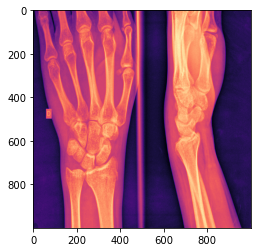

In [347]:

plt.imshow(xray2, 'magma');


In [279]:
vecto = np.ravel(xray2)


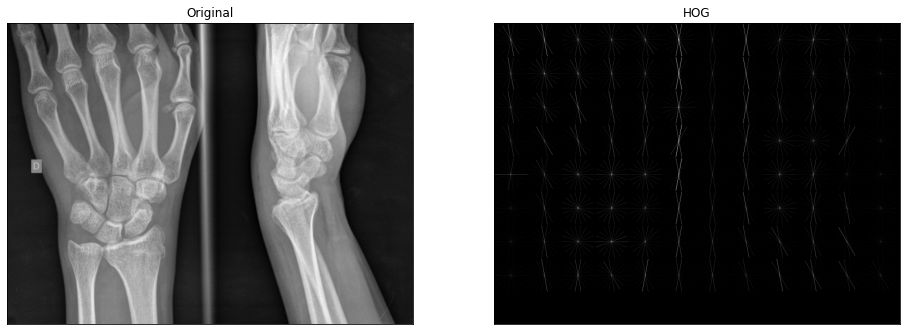

Number of pixels:  442929
Number of HOG features:  2772
np.mean(xray_hog_img): 0.0003925043990108372


In [297]:
## calculate the hog and return a visual representation.
xray_hog, xray_hog_img = hog(
    xray, pixels_per_cell=(64,64), 
    cells_per_block=(2, 2), 
    orientations=9, 
    visualize=True,
    block_norm='L2-Hys')
 
fig, ax = plt.subplots(1,2)
fig.set_size_inches(16,12)
# remove ticks and their labels
[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) 
    for a in ax]
 
ax[0].imshow(np.exp(xray), cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(xray_hog_img, cmap='gray')
ax[1].set_title('HOG')
plt.show()

print('Number of pixels: ', xray.shape[0] * xray.shape[1])
print('Number of HOG features: ', xray_hog.shape[0])
print(f"np.mean(xray_hog_img): {np.mean(xray_hog_img)}")

In [282]:
vetor_img = np.ravel(xray_hog_img)


In [283]:
np.mean(xray_hog_img)


0.0003925043990108372

In [284]:
xray_hog_img.shape


(573, 773)

In [311]:
len(xray_hog)

2772

In [285]:
xray2_hog_r = resize(xray_hog_img, (1000, 1000), anti_aliasing=True)


In [295]:
print('Number of pixels: ', xray.shape[0] * xray.shape[1])
print('Number of HOG features: ', xray_hog.shape[0])


Number of pixels:  442929
Number of HOG features:  2772


# SVD compression

In [312]:
data.shape

(1720, 2320)

In [299]:
u, s, v = np.linalg.svd(data, full_matrices=False)
# inspect shapes of the matrices
print(f'u.shape:{u.shape},s.shape:{s.shape},v.shape:{v.shape}')

u.shape:(1720, 1720),s.shape:(1720,),v.shape:(1720, 2320)


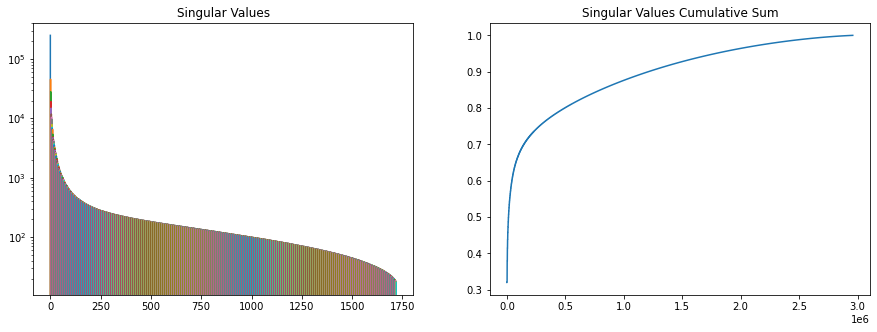

In [339]:
u, s, v = np.linalg.svd(data, full_matrices=False)
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].semilogy(np.diag(s));
ax[0].set_title('Singular Values')
ax[1].plot(np.cumsum(np.diag(s)/np.sum(np.diag(s))));
ax[1].set_title('Singular Values Cumulative Sum');

In [331]:
svd_lst = []
u, s, v = np.linalg.svd(data, full_matrices=False)
for r in (5, 20, 100):
    Xapprox = u[:,:r] @ np.diag(s)[0:r, :r] @ v[:r,:]
    svd_lst.append(Xapprox)    

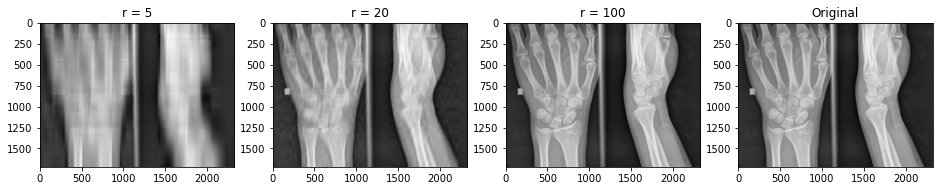

In [344]:
fig, ax = plt.subplots(1,4, figsize=(16,16))
ax[0].imshow(svd_lst[0], cmap='gray')
ax[0].set_title('r = 5')
ax[1].imshow(svd_lst[1], cmap='gray')
ax[1].set_title('r = 20')
ax[2].imshow(svd_lst[2], cmap='gray')
ax[2].set_title('r = 100')
ax[3].imshow(data, cmap='gray')
ax[3].set_title('Original')
plt.show();

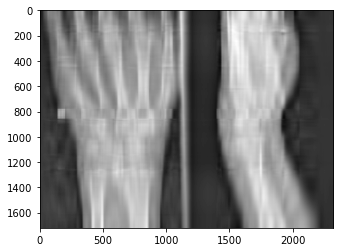

In [346]:
Xapprox = u[:,:10] @ np.diag(s)[0:10, :10] @ v[:10,:]
plt.imshow(Xapprox, 'gray');

In [308]:
np.diag(s)[0:10, :10].shape


(10, 10)

In [309]:
u[:,:10].shape

(1720, 10)

# Image compositions

In [363]:
plot_color_gradients1 = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
plot_color_gradients2 = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                         'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn']
plot_color_gradients3 = ['twilight', 'twilight_shifted', 'hsv']
plot_color_gradients4 = ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy',
                         'RdBu', 'RdYlBu', 'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic']

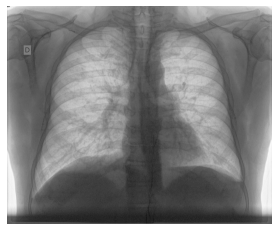

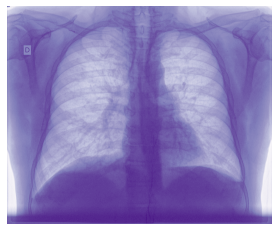

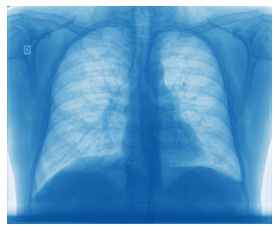

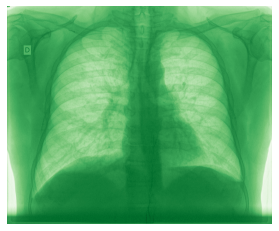

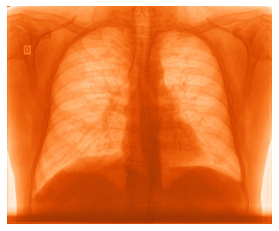

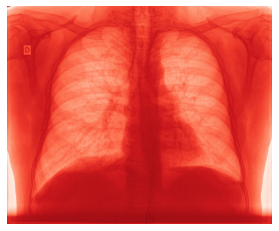

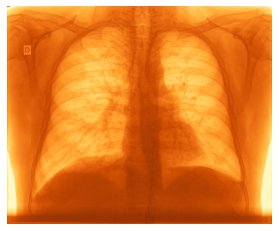

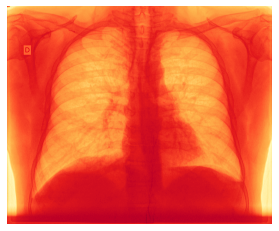

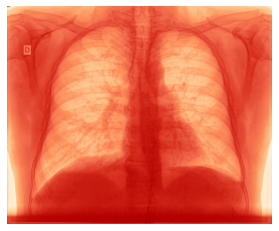

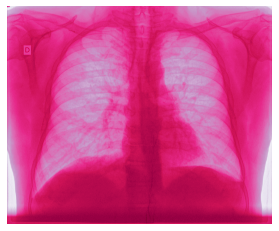

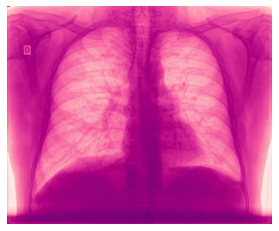

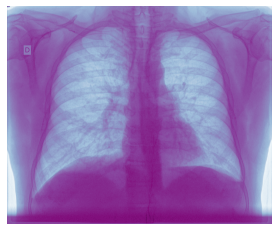

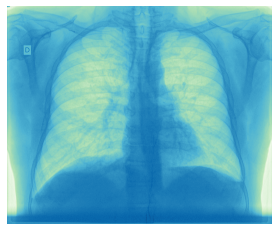

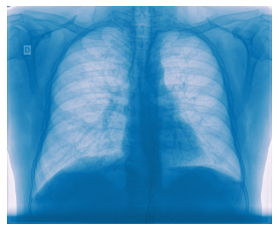

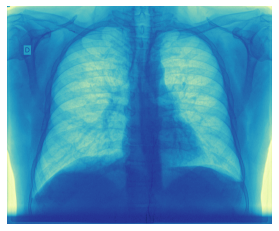

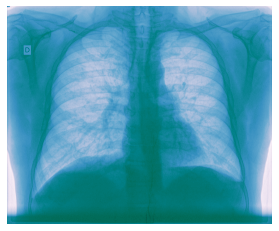

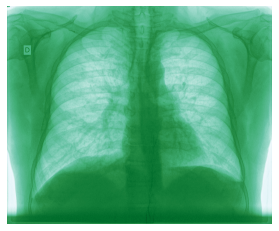

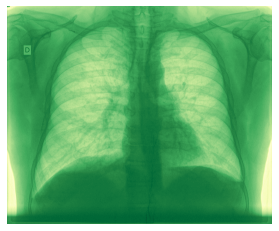

In [357]:
for i in plot_color_gradients2:
    plt.imshow(read_xray(img_train_lst[4]), cmap = i)
    plt.axis('off')
    plt.show()

In [359]:
plot_color_gradients3=['twilight', 'twilight_shifted', 'hsv']

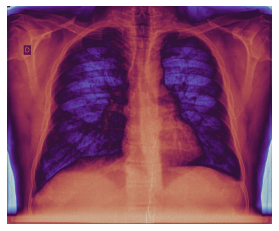

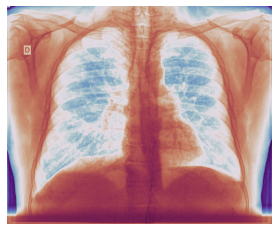

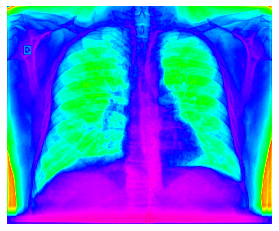

In [360]:
for i in plot_color_gradients3:
    plt.imshow(read_xray(img_train_lst[4]), cmap=i)
    plt.axis('off')
    plt.show()

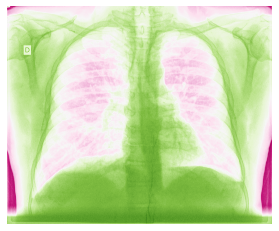

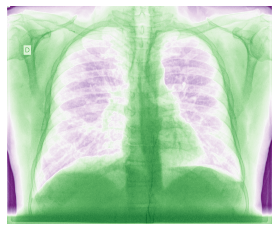

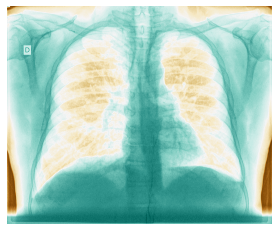

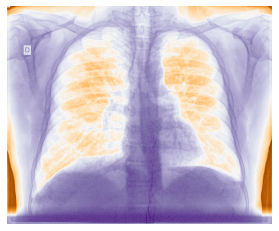

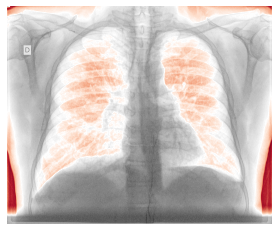

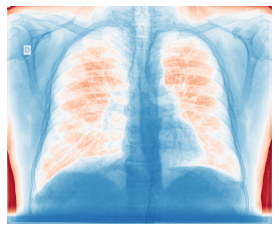

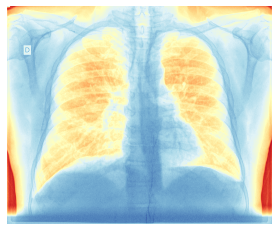

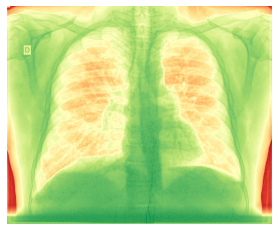

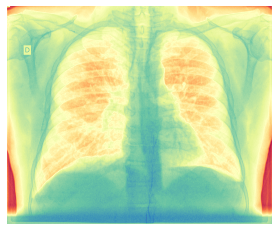

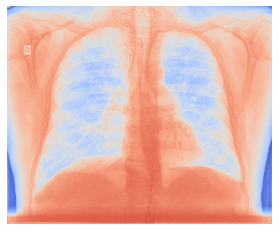

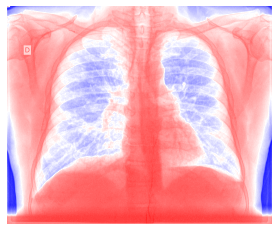

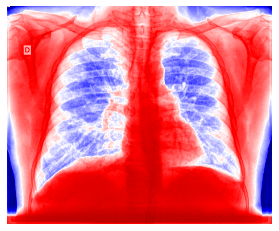

In [364]:
for i in plot_color_gradients4:
    plt.imshow(read_xray(img_train_lst[4]), cmap=i)
    plt.axis('off')
    plt.show()

# Validation

work in progress